In [ ]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns
import re

from sklearn.preprocessing import LabelEncoder

import tensorflow
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Bidirectional
from keras.layers.merge import Concatenate
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('dataset_jobs.csv')

In [ ]:
df.head()

,job_title,seniority_level,employment_type,industries,job_functions
0,Manual Tester,Entry level,Full-time,['Information Technology and Services'],"['Engineering', 'Information Technology']"
1,Field Marketing Representative,Entry level,Full-time,"['Food & Beverages', 'Wholesale', 'Retail']","['Marketing', 'Sales']"
2,Consumer Relations Representative,Associate,Full-time,"['Marketing and Advertising', 'Food & Beverage...",['Other']
3,Software Engineer In Test,Mid-Senior level,Full-time,"['Information Technology and Services', 'Compu...","['Information Technology', 'Quality Assurance']"
4,Electrician,Entry level,Full-time,"['Electrical/Electronic Manufacturing', 'Const...","['Management', 'Manufacturing']"


In [ ]:
df = df[['job_title', 'employment_type', 'seniority_level', 'industries', 'job_functions']]
df.head()

,job_title,employment_type,seniority_level,industries,job_functions
0,Manual Tester,Full-time,Entry level,['Information Technology and Services'],"['Engineering', 'Information Technology']"
1,Field Marketing Representative,Full-time,Entry level,"['Food & Beverages', 'Wholesale', 'Retail']","['Marketing', 'Sales']"
2,Consumer Relations Representative,Full-time,Associate,"['Marketing and Advertising', 'Food & Beverage...",['Other']
3,Software Engineer In Test,Full-time,Mid-Senior level,"['Information Technology and Services', 'Compu...","['Information Technology', 'Quality Assurance']"
4,Electrician,Full-time,Entry level,"['Electrical/Electronic Manufacturing', 'Const...","['Management', 'Manufacturing']"


We can see that for columns industriries, & job functions the values are in list. We will convert the list of elements to a one hot vectors i.e., each vector/column created equivalent to each element in the list.

### Data preparation

In [ ]:
# Check data types
df.dtypes

job_title          object
employment_type    object
seniority_level    object
industries         object
job_functions      object
dtype: object

In [ ]:
# Encoding employment_type
dummies = pd.get_dummies(df['employment_type'])
dummies

,Contract,Full-time,Internship,Other,Part-time,Temporary,Volunteer
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
4994,0,1,0,0,0,0,0
4995,0,1,0,0,0,0,0
4996,0,0,0,0,0,1,0
4997,0,1,0,0,0,0,0


In [ ]:
# Merge dummues with original df 
df = df.merge(dummies, right_index=True, left_index=True)
df.head()

,job_title,employment_type,seniority_level,industries,job_functions,Contract,Full-time,Internship,Other,Part-time,Temporary,Volunteer
0,Manual Tester,Full-time,Entry level,['Information Technology and Services'],"['Engineering', 'Information Technology']",0,1,0,0,0,0,0
1,Field Marketing Representative,Full-time,Entry level,"['Food & Beverages', 'Wholesale', 'Retail']","['Marketing', 'Sales']",0,1,0,0,0,0,0
2,Consumer Relations Representative,Full-time,Associate,"['Marketing and Advertising', 'Food & Beverage...",['Other'],0,1,0,0,0,0,0
3,Software Engineer In Test,Full-time,Mid-Senior level,"['Information Technology and Services', 'Compu...","['Information Technology', 'Quality Assurance']",0,1,0,0,0,0,0
4,Electrician,Full-time,Entry level,"['Electrical/Electronic Manufacturing', 'Const...","['Management', 'Manufacturing']",0,1,0,0,0,0,0


Since we are predicting 3 outputs, create a dataset for each output.

In [ ]:
df.columns

Index(['job_title', 'employment_type', 'seniority_level', 'industries',
       'job_functions', 'Contract', 'Full-time', 'Internship', 'Other',
       'Part-time', 'Temporary', 'Volunteer'],
      dtype='object')

In [ ]:
df_seniority = df[['job_title', 'employment_type','Contract', 'Full-time', 'Internship', 'Other', 'Part-time', 'Temporary', 'Volunteer', 'seniority_level']]
df_industry = df[['job_title', 'Contract', 'employment_type','Full-time', 'Internship', 'Other', 'Part-time', 'Temporary', 'Volunteer', 'industries']]
df_jobfunc = df[['job_title', 'Contract', 'employment_type','Full-time', 'Internship', 'Other', 'Part-time', 'Temporary', 'Volunteer', 'job_functions']]

### Industries

In [ ]:
# Convert string to lists
df_industry['industries'] = df_industry['industries'].apply(eval)

In [ ]:
# Convert list of elements in the column to series dataframe to get unique items
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

unique_industries = to_1D(df_industry['industries']).unique()

In [ ]:
unique_industries

array(['Information Technology and Services', 'Food & Beverages',
       'Wholesale', 'Retail', 'Marketing and Advertising',
       'Consumer Goods', 'Computer Software', 'Internet',
       'Electrical/Electronic Manufacturing', 'Construction',
       'Security and Investigations', 'Biotechnology', 'Chemicals',
       'Pharmaceuticals', 'Law Practice', 'Legal Services',
       'Management Consulting', 'Staffing and Recruiting',
       'Human Resources', 'Nonprofit Organization Management',
       'Higher Education', 'Education Management', 'Aviation & Aerospace',
       'Airlines/Aviation', 'Medical Practice', 'Real Estate',
       'Financial Services', 'Insurance', 'Banking',
       'Hospital & Health Care', 'Food Production',
       'Mechanical or Industrial Engineering', 'Accounting',
       'Health, Wellness and Fitness', 'Research',
       'Government Administration', 'Telecommunications', 'Entertainment',
       'Events Services', 'Hospitality', 'Automotive', 'Machinery',
       

In [ ]:
# Convert list of industries to sequence of industries
for index, value in enumerate(df_industry['industries']):
  df_industry['industries'][index] = ", ".join(value)

In [ ]:
df_industry.head()

,job_title,Contract,employment_type,Full-time,Internship,Other,Part-time,Temporary,Volunteer,industries
0,Manual Tester,0,Full-time,1,0,0,0,0,0,Information Technology and Services
1,Field Marketing Representative,0,Full-time,1,0,0,0,0,0,"Food & Beverages, Wholesale, Retail"
2,Consumer Relations Representative,0,Full-time,1,0,0,0,0,0,"Marketing and Advertising, Food & Beverages, C..."
3,Software Engineer In Test,0,Full-time,1,0,0,0,0,0,"Information Technology and Services, Computer ..."
4,Electrician,0,Full-time,1,0,0,0,0,0,"Electrical/Electronic Manufacturing, Construct..."


In [ ]:
# create a column for each industry in unique_industries. If industry is present in the industries feature it will return 1 else 0 like one hot coding
for industry in unique_industries:
    df_industry.loc[df_industry['industries'].str.contains(industry, regex=True), industry] = 1
    df_industry.loc[~df_industry['industries'].str.contains(industry, regex=True), industry] = 0
    df_industry[industry] = df_industry[industry].astype('uint8')

In [ ]:
df_industry.head()

,job_title,Contract,employment_type,Full-time,Internship,Other,Part-time,Temporary,Volunteer,industries,Information Technology and Services,Food & Beverages,Wholesale,Retail,Marketing and Advertising,Consumer Goods,Computer Software,Internet,Electrical/Electronic Manufacturing,Construction,Security and Investigations,Biotechnology,Chemicals,Pharmaceuticals,Law Practice,Legal Services,Management Consulting,Staffing and Recruiting,Human Resources,Nonprofit Organization Management,Higher Education,Education Management,Aviation & Aerospace,Airlines/Aviation,Medical Practice,Real Estate,Financial Services,Insurance,Banking,Hospital & Health Care,...,Publishing,Newspapers,Religious Institutions,Political Organization,Printing,Public Relations and Communications,International Trade and Development,Recreational Facilities and Services,Farming,Nanotechnology,Semiconductors,Venture Capital & Private Equity,Photography,Libraries,Railroad Manufacture,Outsourcing/Offshoring,Music,Mining & Metals,E-Learning,Executive Office,Program Development,Wireless,"Glass, Ceramics & Concrete",Motion Pictures and Film,Museums and Institutions,Fine Art,Performing Arts,Philanthropy,International Affairs,Translation and Localization,Wine and Spirits,Graphic Design,Import and Export,Furniture,Government Relations,Legislative Office,Alternative Medicine,Sporting Goods,Animation,Law Enforcement
0,Manual Tester,0,Full-time,1,0,0,0,0,0,Information Technology and Services,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Field Marketing Representative,0,Full-time,1,0,0,0,0,0,"Food & Beverages, Wholesale, Retail",0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Consumer Relations Representative,0,Full-time,1,0,0,0,0,0,"Marketing and Advertising, Food & Beverages, C...",0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Software Engineer In Test,0,Full-time,1,0,0,0,0,0,"Information Technology and Services, Computer ...",1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Electrician,0,Full-time,1,0,0,0,0,0,"Electrical/Electronic Manufacturing, Construct...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_industry.shape

(4999, 151)

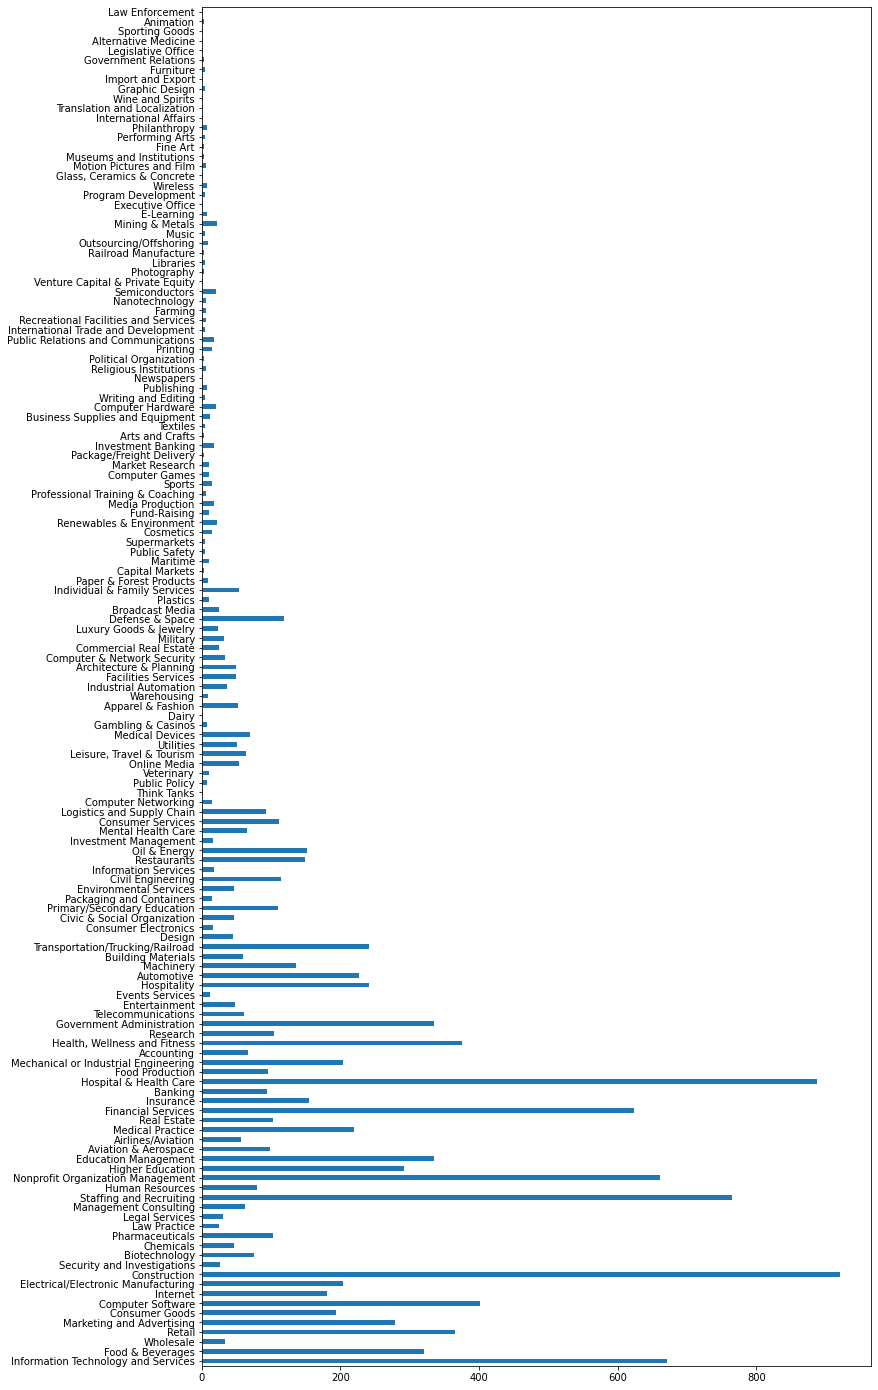

In [ ]:
# Count plot for industries
plt.figure(figsize=(12, 25))
industry_labels = df_industry[df_industry.columns[10:]]
industry_labels.sum(axis=0).plot.barh()

### Job functions

In [ ]:
# Convert string to lists
df_jobfunc['job_functions'] = df_jobfunc['job_functions'].apply(eval)

In [ ]:
# Convert list of elements in the column to series dataframe to get unique items
unique_jobs = to_1D(df_jobfunc['job_functions']).unique()

In [ ]:
unique_jobs

array(['Engineering', 'Information Technology', 'Marketing', 'Sales',
       'Other', 'Quality Assurance', 'Management', 'Manufacturing',
       'Legal', 'Design', 'Art/Creative', 'Education', 'Training',
       'Health Care Provider', 'Accounting/Auditing', 'Consulting',
       'Analyst', 'Human Resources', 'Business Development', 'Research',
       'Production', 'Distribution', 'General Business', 'Finance',
       'Supply Chain', 'Customer Service', 'Administrative',
       'Public Relations', 'Writing/Editing', 'Project Management',
       'Science', 'Strategy/Planning', 'Advertising',
       'Product Management', 'Purchasing'], dtype=object)

In [ ]:
# Convert list of job functions to sequence of job functions
for index, value in enumerate(df_jobfunc['job_functions']):
  df_jobfunc['job_functions'][index] = ", ".join(value)

In [ ]:
df_jobfunc.head()

,job_title,Contract,employment_type,Full-time,Internship,Other,Part-time,Temporary,Volunteer,job_functions
0,Manual Tester,0,Full-time,1,0,0,0,0,0,"Engineering, Information Technology"
1,Field Marketing Representative,0,Full-time,1,0,0,0,0,0,"Marketing, Sales"
2,Consumer Relations Representative,0,Full-time,1,0,0,0,0,0,Other
3,Software Engineer In Test,0,Full-time,1,0,0,0,0,0,"Information Technology, Quality Assurance"
4,Electrician,0,Full-time,1,0,0,0,0,0,"Management, Manufacturing"


In [ ]:
# create a column for each job function in unique_jobs. If job function is present in the job_functions feature it will return 1 else 0 like one hot coding
for jobfunc in unique_jobs:
    df_jobfunc.loc[df_jobfunc['job_functions'].str.contains(jobfunc, regex=True), jobfunc] = 1
    df_jobfunc.loc[~df_jobfunc['job_functions'].str.contains(jobfunc, regex=True), jobfunc] = 0
    df_jobfunc[jobfunc] = df_jobfunc[jobfunc].astype('uint8')

In [ ]:
df_jobfunc.head()

,job_title,Contract,employment_type,Full-time,Internship,Other,Part-time,Temporary,Volunteer,job_functions,Engineering,Information Technology,Marketing,Sales,Quality Assurance,Management,Manufacturing,Legal,Design,Art/Creative,Education,Training,Health Care Provider,Accounting/Auditing,Consulting,Analyst,Human Resources,Business Development,Research,Production,Distribution,General Business,Finance,Supply Chain,Customer Service,Administrative,Public Relations,Writing/Editing,Project Management,Science,Strategy/Planning,Advertising,Product Management,Purchasing
0,Manual Tester,0,Full-time,1,0,0,0,0,0,"Engineering, Information Technology",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Field Marketing Representative,0,Full-time,1,0,0,0,0,0,"Marketing, Sales",0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Consumer Relations Representative,0,Full-time,1,0,1,0,0,0,Other,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Software Engineer In Test,0,Full-time,1,0,0,0,0,0,"Information Technology, Quality Assurance",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Electrician,0,Full-time,1,0,0,0,0,0,"Management, Manufacturing",0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


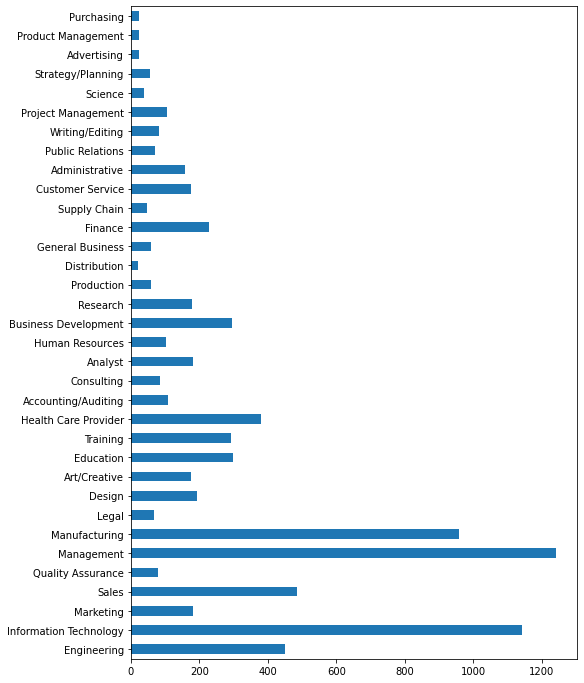

In [ ]:
# Count plot for job functions
plt.figure(figsize=(8, 12))
job_func_labels = df_jobfunc[df_jobfunc.columns[10:]]
job_func_labels.sum(axis=0).plot.barh()

In [ ]:
df_jobfunc.shape

(4999, 44)

### Seniority Level

In [ ]:
df_seniority.head()

,job_title,employment_type,Contract,Full-time,Internship,Other,Part-time,Temporary,Volunteer,seniority_level
0,Manual Tester,Full-time,0,1,0,0,0,0,0,Entry level
1,Field Marketing Representative,Full-time,0,1,0,0,0,0,0,Entry level
2,Consumer Relations Representative,Full-time,0,1,0,0,0,0,0,Associate
3,Software Engineer In Test,Full-time,0,1,0,0,0,0,0,Mid-Senior level
4,Electrician,Full-time,0,1,0,0,0,0,0,Entry level


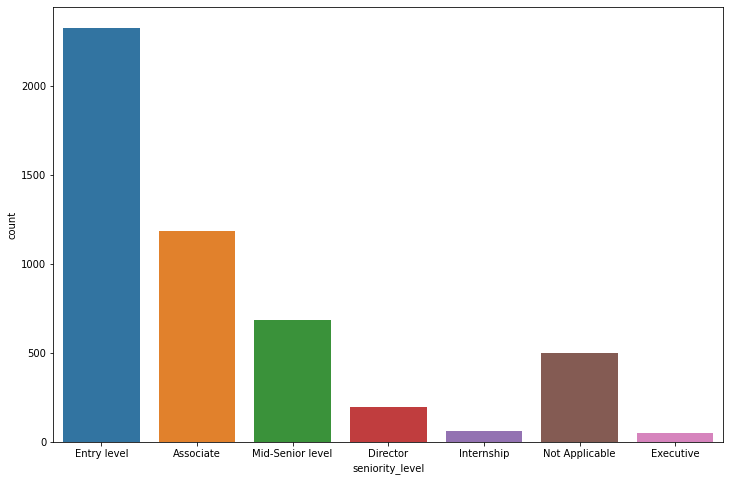

In [ ]:
# Count plot for seniority_level
plt.figure(figsize = (12, 8))
sns.countplot(df_seniority['seniority_level'])

In [ ]:
#Encode the target variable 
le = LabelEncoder()
df_seniority['seniority_level'] = le.fit_transform(df_seniority['seniority_level'])
print(f'Target classes : {le.classes_}')

Target classes : ['Associate' 'Director' 'Entry level' 'Executive' 'Internship'
 'Mid-Senior level' 'Not Applicable']


In [ ]:
df_seniority.head()

,job_title,employment_type,Contract,Full-time,Internship,Other,Part-time,Temporary,Volunteer,seniority_level
0,Manual Tester,Full-time,0,1,0,0,0,0,0,2
1,Field Marketing Representative,Full-time,0,1,0,0,0,0,0,2
2,Consumer Relations Representative,Full-time,0,1,0,0,0,0,0,0
3,Software Engineer In Test,Full-time,0,1,0,0,0,0,0,5
4,Electrician,Full-time,0,1,0,0,0,0,0,2


In [ ]:
df_seniority.to_csv('seniority_level_data.csv', index=False)

# **Create LSTM models for each Output**

Create helper functions to build, &  train LSTM models.

In [ ]:
def create_lstm_model(input_1, input_2, vocab_size, embedding_matrix, n_classes, model_name):
  # create the first submodel that accepts text data (input_1)
  embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1)
  # Add 2 bidirectional LSTMs
  x = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
  x = Bidirectional(LSTM(64))(x)
  #LSTM_Layer_1 = LSTM(128, return_sequences=True)(embedding_layer)
  #LSTM_Layer_2 = LSTM(64)(LSTM_Layer_1)

  #creates a second submodel that accepts meta data (numeric data)(input_2)
  dense_layer_1 = Dense(10, activation='relu')(input_2)
  dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

  # Concatenate both inputs
  concat_layer = Concatenate()([x, dense_layer_2])
  dense_layer_3 = Dense(10, activation='relu')(concat_layer)
  #dense_layer_4 = Dense(32, activation='relu')(dense_layer_3)
  output = Dropout(0.5)(dense_layer_3)
  output = Dense(n_classes, activation='softmax')(output)
  model = Model(inputs=[input_1, input_2], outputs=output)

  # Compile the model  
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])
  print(model.summary())

  # Plot model 
  plot_model(model, to_file=f'{model_name}.png', show_shapes=True)
  
  return model

### Create LSTM model for Seniority Level

We need to create word vectors for job_title using Glove embeddings.So download [glove.6B.100d.txt](https://nlp.stanford.edu/data/glove.6B.zip) file into out local directory.

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-09-19 05:02:46--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-19 05:02:46--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip         15%[==>                 ] 129.63M  5.00MB/s    eta 1m 56s ^C


In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls

dataset_jobs.csv   glove.6B.300d.txt  lstm_model_industries.png
glove.6B.100d.txt  glove.6B.50d.txt   lstm_model_seniority.png
glove.6B.200d.txt  glove.6B.zip       sample_data


In [ ]:
import os 
# Remove zip file to save memory
os.system('rm glove.6B.zip')

0

In [ ]:
# Define a function to create word vectors
def glove_embedding_matrix(vocab_size):
  embeddings_dictionary = dict()

  glove_file = open('glove.6B.300d.txt', encoding="utf8")

  for line in glove_file:
      records = line.split()
      word = records[0]
      vector_dimensions = np.asarray(records[1:], dtype='float32')
      embeddings_dictionary[word] = vector_dimensions

  glove_file.close()

  embedding_matrix = np.zeros((vocab_size, 300))
  for word, index in tokenizer.word_index.items():
      embedding_vector = embeddings_dictionary.get(word)
      if embedding_vector is not None:
          embedding_matrix[index] = embedding_vector
  return embedding_matrix

In [ ]:
# Features & labels
seniority_feats = df_seniority.drop('seniority_level', axis=1)
seniority_labels = df_seniority['seniority_level']

# Split the data into 80% train & 20% test set
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(seniority_feats, seniority_labels, test_size=0.2, random_state=42)

print(f'Train shape : {X_train_s.shape}')
print(f'Test shape : {X_test_s.shape}')

Train shape : (3999, 9)
Test shape : (1000, 9)


In [ ]:
n_classes_s = y_train_s.nunique()
n_classes_s

7

In [ ]:
X_train_s.head()

,job_title,employment_type,Contract,Full-time,Internship,Other,Part-time,Temporary,Volunteer
1738,Teacher,Full-time,0,1,0,0,0,0,0
4943,Digital Forensics Investigator/Examiner,Full-time,0,1,0,0,0,0,0
2916,Control & Instrumention Engineer,Full-time,0,1,0,0,0,0,0
1595,Building Materials Specialist,Full-time,0,1,0,0,0,0,0
3214,"Worksite Organizer, MA",Contract,1,0,0,0,0,0,0


In [ ]:
train_x = X_train_s[['job_title','employment_type']]
train_y = X_test_s[['job_title','employment_type']]

## Sklearn input

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# Create Function Transformer to use Feature Union
def get_numeric_data(x):
 return [record[:-2].astype(float) for record in x]
def get_text_data(x):
 return [record[-1] for record in x]
transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)
#transfomer_numeric = FunctionTransformer(Num_dm)
#transformer_text = FunctionTransformer(text_dm)
# Create a pipeline to concatenate Tfidf Vector and Numeric data
# Use RandomForestClassifier as an example
#pipeline = Pipeline([
 #('features', FeatureUnion([
 #('numeric_features', Pipeline([
 #('selector', transfomer_numeric)
 #])),
 #('text_features', Pipeline([
 #('selector', transformer_text),
 #('vec', TfidfVectorizer(analyzer='word'))
 #]))
 #])),
 #('clf', RandomForestClassifier())
#])
from sklearn.compose import make_column_transformer
pipeline = Pipeline([
    ('transformer',  make_column_transformer((TfidfVectorizer(), 'job_title'),
                                             (OneHotEncoder(), ['employment_type']), remainder='passthrough')),
    ('clf', RandomForestClassifier()),
])
# Grid Search Parameters for RandomForest
param_grid = {'clf__n_estimators': np.linspace(1, 100, 10, dtype=int),
 'clf__min_samples_split': [3, 10],
 'clf__min_samples_leaf': [3],
 'clf__max_features': [10],
 'clf__max_depth': [None],
 'clf__criterion': ['gini'],
 'clf__bootstrap': [False]}
# Training config
kfold = StratifiedKFold(n_splits=5)
scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

# Perform GridSearch
rf_model = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=scoring,
 refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
rf_model.fit(train_x, y_train_s.values)
rf_best = rf_model.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.9s finished


In [ ]:
rf_best.predict(X_test_s[['job_title','employment_type']])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 5, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2,

In [ ]:
### Pytorch
## using LSTM
import torch.nn as nn
class LSTMTextClassifier(nn.Module):
  def __init__(self, vocab_size, embed_size, lstm_size, dense_size, numeric_feature_size, output_size, lstm_layers=1, dropout=0.1):
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.lstm_size = lstm_size
    self.output_size = output_size
    self.lstm_layers = lstm_layers
    self.dropout = dropout
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(lstm_size, dense_size)
    self.fc2 = nn.Linear(dense_size + numeric_feature_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
    weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
    return hidden
 
  def forward(self, nn_input_text, nn_input_meta, hidden_state):
    batch_size = nn_input_text.size(0)
    nn_input_text = nn_input_text.long()
    embeds = self.embedding(nn_input_text)
    lstm_out, hidden_state = self.lstm(embeds, hidden_state)
    lstm_out = lstm_out[-1,:,:]
    lstm_out = self.dropout(lstm_out)
    dense_out = self.fc1(lstm_out)
    concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
    out = self.fc2(concat_layer)
    logps = self.softmax(out)
    return logps, hidden_state

class BertTextClassifier(nn.Module):
   def __init__(self, hidden_size, dense_size, numeric_feature_size, output_size, dropout=0.1):
     super().__init__()
     self.output_size = output_size
     self.dropout = dropout   
     # Use pre-trained BERT model
     self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True)
     for param in self.bert.parameters():
       param.requires_grad = True
     self.weights = nn.Parameter(torch.rand(13, 1))
     self.dropout = nn.Dropout(dropout)
     self.fc1 = nn.Linear(hidden_size, dense_size)
     self.fc2 = nn.Linear(dense_size + numeric_feature_size, output_size)
     self.softmax = nn.LogSoftmax(dim=1)
 
   def forward(self, input_ids, nn_input_meta):
     all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
     batch_size = input_ids.shape[0]
     ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
     atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
     atten = F.softmax(atten.view(-1), dim=0)
     feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])
     dense_out = self.fc1(self.dropout(feature))
     concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
     out = self.fc2(concat_layer)
     logps = self.softmax(out)
     return logps

In [ ]:
# Encode the target label
y_train_s = to_categorical(y_train_s)
y_test_s = to_categorical(y_test_s)

In [ ]:
X_train_s['job_title'] = X_train_s['job_title'].astype('str')
X_test_s['job_title'] = X_test_s['job_title'].astype('str')

In [ ]:
X_train_sc = X_train_s.copy()
X_test_sc = X_test_s.copy()
y_train_sc = y_train_s.copy()
y_test_sc = y_test_s.copy()

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Convert to lower case
    sentence = sentence.lower()

    return sentence

X1_train_sc = []
sentences1 = X_train_sc['job_title'].tolist()
for sen in sentences1:
    X1_train_sc.append(preprocess_text(sen))

X1_test_sc = []
sentences2 = X_test_sc['job_title'].tolist()
for sen in sentences2:
    X1_test_sc.append(preprocess_text(sen))

In [ ]:
# Convert text inputs into word vectors
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X1_train_sc)

X1_train_sc = tokenizer.texts_to_sequences(X1_train_sc)
X1_test_sc = tokenizer.texts_to_sequences(X1_test_sc)

vocab_size_sc = len(tokenizer.word_index) + 1

# Maximum sequence length of Job title
maxlen_s = 100

# Pad sequences of Job titles
X1_train_sc = pad_sequences(X1_train_sc, padding='post', maxlen=maxlen_s)
X1_test_sc = pad_sequences(X1_test_sc, padding='post', maxlen=maxlen_s)

In [ ]:
X1_train_sc

array([[ 19,   0,   0, ...,   0,   0,   0],
       [123, 171, 189, ...,   0,   0,   0],
       [ 72,   5,   0, ...,   0,   0,   0],
       ...,
       [  7,  10,  98, ...,   0,   0,   0],
       [167,  26,  12, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [ ]:
X1_test_sc

array([[ 51,  12,   0, ...,   0,   0,   0],
       [ 22, 410,  83, ...,   0,   0,   0],
       [  2, 213,   0, ...,   0,   0,   0],
       ...,
       [153, 508,  30, ...,   0,   0,   0],
       [633,   8,   0, ...,   0,   0,   0],
       [ 51,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [ ]:
# Get embedding matrix
embedding_matrix_s = glove_embedding_matrix(vocab_size_sc)

In [ ]:
# Now let's see second input data/numeric data/meta data
X2_train_sc = X_train_sc[X_train_sc.columns[2:]]
X2_test_sc = X_test_sc[X_test_sc.columns[2:]]

In [ ]:
X2_train_sc.head()

,Contract,Full-time,Internship,Other,Part-time,Temporary,Volunteer
1738,0,1,0,0,0,0,0
4943,0,1,0,0,0,0,0
2916,0,1,0,0,0,0,0
1595,0,1,0,0,0,0,0
3214,1,0,0,0,0,0,0


In [ ]:
X2_test_sc.head()

,Contract,Full-time,Internship,Other,Part-time,Temporary,Volunteer
84,0,1,0,0,0,0,0
2470,0,1,0,0,0,0,0
2804,0,1,0,0,0,0,0
4987,0,1,0,0,0,0,0
4924,0,1,0,0,0,0,0


In [ ]:
# Inputs for text & numeric data
input_1_s = Input(shape=(maxlen_s,))
input_2_s = Input(shape=(X2_train_sc.shape[1],))

In [ ]:
# Create LSTM model
lstm_model_1 = create_lstm_model(input_1_s, input_2_s, vocab_size_sc, embedding_matrix_s, n_classes_s, 'lstm_model_seniority')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     989700      input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 100, 128)     186880      embedding_2[0][0]                
____________________________________________________________________________________________

In [ ]:
# Train the model 
history_1 = lstm_model_1.fit(x=[X1_train_sc, X2_train_sc], y = y_train_sc, batch_size=32, epochs=20, verbose=1, validation_split=0.1)

Epoch 1/20
113/113 [==============================] - 40s 293ms/step - loss: 1.6396 - acc: 0.4079 - val_loss: 1.2675 - val_acc: 0.5950
Epoch 2/20
113/113 [==============================] - 31s 276ms/step - loss: 1.4112 - acc: 0.5018 - val_loss: 1.1858 - val_acc: 0.6025
Epoch 3/20
113/113 [==============================] - 31s 278ms/step - loss: 1.2991 - acc: 0.5365 - val_loss: 1.0855 - val_acc: 0.6275
Epoch 4/20
113/113 [==============================] - 31s 277ms/step - loss: 1.2429 - acc: 0.5546 - val_loss: 1.0854 - val_acc: 0.6200
Epoch 5/20
113/113 [==============================] - 31s 276ms/step - loss: 1.1751 - acc: 0.5752 - val_loss: 1.0682 - val_acc: 0.6275
Epoch 6/20
113/113 [==============================] - 31s 278ms/step - loss: 1.1329 - acc: 0.5721 - val_loss: 1.0583 - val_acc: 0.6250
Epoch 7/20
113/113 [==============================] - 31s 279ms/step - loss: 1.0902 - acc: 0.5904 - val_loss: 1.0465 - val_acc: 0.6100
Epoch 8/20
113/113 [==============================] - 3

Model was overfitting after 20 epochs, so 20 epochs are considered as final. Model performance can be improved by adding more data with equal distribution of sampels during training.

### Model evaluation on test data

In [ ]:
score_s = lstm_model_1.evaluate(x=[X1_test_sc, X2_test_sc], y=y_test_sc, verbose=1)

print("Test loss:", round(score_s[0],3))
print("Test Accuracy:", round(score_s[1],3))

32/32 [==============================] - 2s 68ms/step - loss: 1.5185 - acc: 0.5800
Test loss: 1.518
Test Accuracy: 0.58


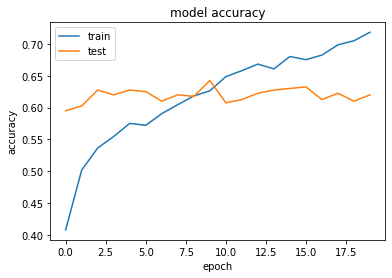

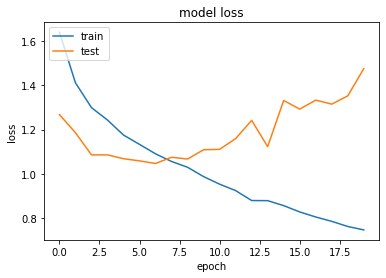

In [ ]:
# Plot loss & accuracy for training & testing sets
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Model predictions on test data

In [ ]:
y_pred_s = lstm_model_1.predict(x=[X1_test_sc, X2_test_sc])
y_pred_s = y_pred_s.argmax(axis=1)

In [ ]:
# Check 10 predictions
y_pred_s[:10]

array([2, 2, 2, 2, 2, 0, 2, 5, 2, 5])

In [ ]:
# Decode the predictions
y_pred_s = le.inverse_transform(y_pred_s)
y_pred_s[:10]

array(['Entry level', 'Entry level', 'Entry level', 'Entry level',
       'Entry level', 'Associate', 'Entry level', 'Mid-Senior level',
       'Entry level', 'Mid-Senior level'], dtype=object)

In [ ]:
# Add y_pred_s in  X_test_s
X_test_preds = X_test_s 
X_test_preds['original_seniority_level'] = le.inverse_transform(y_test_s.argmax(axis=1))
X_test_preds['predictions_seniority_level'] = y_pred_s

In [ ]:
X_test_preds = X_test_preds.drop(['Contract','Full-time', 'Internship', 'Other', 'Part-time', 'Temporary', 'Volunteer'], axis=1)
X_test_preds.head()

,job_title,employment_type,original_seniority_level,predictions_seniority_level
84,Clinical Trial Coordinator,Full-time,Entry level,Entry level
2470,Crisis Worker/Police Team (190331) - 90% FTE,Full-time,Entry level,Entry level
2804,Drill Technician - CO7813750,Full-time,Entry level,Entry level
4987,Journeyman Welders,Full-time,Entry level,Entry level
4924,Semi-Skilled Laborer,Full-time,Entry level,Entry level


### Create LSTM model for Industries

In [ ]:
def create_lstm_model_i(input_1, input_2, vocab_size, embedding_matrix, n_classes, model_name):
  # create the first submodel that accepts text data (input_1)
  embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1)
  # Add 2 bidirectional LSTMs
  x = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
  x = Bidirectional(LSTM(64))(x)

  #creates a second submodel that accepts meta data (numeric data)(input_2)
  dense_layer_1 = Dense(64, activation='relu')(input_2)
  dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)

  # Concatenate both inputs
  concat_layer = Concatenate()([x, dense_layer_2])
  dense_layer_3 = Dense(10, activation='relu')(concat_layer)
  #dense_layer_4 = Dense(32, activation='relu')(dense_layer_3)
  output = Dropout(0.1)(dense_layer_3)
  output = Dense(n_classes, activation='sigmoid')(output)
  model = Model(inputs=[input_1, input_2], outputs=output)

  # Compile the model  
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])
  print(model.summary())

  # Plot model 
  plot_model(model, to_file=f'{model_name}.png', show_shapes=True)
  
  return model

In [ ]:
df_industry.columns[:10]

Index(['job_title', 'Contract', 'employment_type', 'Full-time', 'Internship',
       'Other', 'Part-time', 'Temporary', 'Volunteer', 'industries'],
      dtype='object')

In [ ]:
# Features & labels
industry_feats = df_industry[df_industry.columns[:10]]
industry_labels = df_industry[df_industry.columns[10:]]

# Split the data into 80% train & 20% test set
X_train_ui, X_test_ui, y_train_ui, y_test_ui = train_test_split(industry_feats, industry_labels, test_size=0.2, random_state=42)

print(f'Train shape : {X_train_ui.shape}')
print(f'Test shape : {X_test_ui.shape}')

Train shape : (3999, 10)
Test shape : (1000, 10)


In [ ]:
n_classes_ui = y_train_ui.shape[1]

In [ ]:
X_train_ui['job_title'] = X_train_ui['job_title'].astype('str')
X_test_ui['job_title'] = X_test_ui['job_title'].astype('str')

In [ ]:
X_train_uic = X_train_ui.copy()
X_test_uic = X_test_ui.copy()
y_train_uic = y_train_ui.copy()
y_test_uic = y_test_ui.copy()

In [ ]:
X1_train_uic = []
sentences1 = X_train_uic['job_title'].tolist()
for sen in sentences1:
    X1_train_uic.append(preprocess_text(sen))

X1_test_uic = []
sentences2 = X_test_uic['job_title'].tolist()
for sen in sentences2:
    X1_test_uic.append(preprocess_text(sen))

In [ ]:
# Convert text inputs into word vectors
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X1_train_uic)

X1_train_uic = tokenizer.texts_to_sequences(X1_train_uic)
X1_test_uic = tokenizer.texts_to_sequences(X1_test_uic)

vocab_size_uic = len(tokenizer.word_index) + 1

# Maximum sequence length of Job title
maxlen_ui = 50

# Pad sequences of Job titles
X1_train_uic = pad_sequences(X1_train_uic, padding='post', maxlen=maxlen_ui)
X1_test_uic = pad_sequences(X1_test_uic, padding='post', maxlen=maxlen_ui)

In [ ]:
# Get embedding matrix
embedding_matrix_ui = glove_embedding_matrix(vocab_size_uic)

In [ ]:
# Now let's see second input data/numeric data/meta data
X2_train_uic = X_train_ui[['Contract','Full-time', 'Internship', 'Other', 'Part-time', 'Temporary']]
X2_test_uic = X_test_ui[['Contract','Full-time', 'Internship', 'Other', 'Part-time', 'Temporary']]

In [ ]:
# Inputs for text & numeric data
input_1_ui = Input(shape=(maxlen_ui,))
input_2_ui = Input(shape=(X2_train_uic.shape[1],))

In [ ]:
# Create LSTM model
lstm_model_2 = create_lstm_model_i(input_1_ui, input_2_ui, vocab_size_uic, embedding_matrix_ui, n_classes_ui, 'lstm_model_industries')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 300)      989700      input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 50, 128)      186880      embedding_4[0][0]                
____________________________________________________________________________________________

In [ ]:
# Train the model 
history_2 = lstm_model_2.fit(x=[X1_train_uic, X2_train_uic], y = y_train_uic, batch_size=64, epochs=50, verbose=1, validation_split=0.1)

Epoch 1/50
57/57 [==============================] - 21s 242ms/step - loss: 0.4560 - acc: 0.0081 - val_loss: 0.1632 - val_acc: 0.0425
Epoch 2/50
57/57 [==============================] - 12s 210ms/step - loss: 0.1172 - acc: 0.0300 - val_loss: 0.0761 - val_acc: 0.0425
Epoch 3/50
57/57 [==============================] - 12s 211ms/step - loss: 0.0869 - acc: 0.0609 - val_loss: 0.0732 - val_acc: 0.0425
Epoch 4/50
57/57 [==============================] - 12s 210ms/step - loss: 0.0824 - acc: 0.0628 - val_loss: 0.0725 - val_acc: 0.0425
Epoch 5/50
57/57 [==============================] - 12s 211ms/step - loss: 0.0804 - acc: 0.0772 - val_loss: 0.0722 - val_acc: 0.1725
Epoch 6/50
57/57 [==============================] - 12s 210ms/step - loss: 0.0786 - acc: 0.0759 - val_loss: 0.0719 - val_acc: 0.1725
Epoch 7/50
57/57 [==============================] - 12s 210ms/step - loss: 0.0781 - acc: 0.0770 - val_loss: 0.0717 - val_acc: 0.0575
Epoch 8/50
57/57 [==============================] - 12s 210ms/step - 

Model was overfitting after 50 epochs, so 50 epochs are considered as final. Accuracy is okay but not good due to the presenence of unbalanced classes during training. Higher model complexity leads to lower model performance. Model performance can be improved further by adding more data with equal distribution of samples for all labels during training.

### Model evaluation on test data

In [ ]:
score_i = lstm_model_2.evaluate(x=[X1_test_uic, X2_test_uic], y=y_test_uic, verbose=1)

print("Test loss:", round(score_i[0],3))
print("Test Accuracy:", round(score_i[1],3))

32/32 [==============================] - 1s 34ms/step - loss: 0.0691 - acc: 0.2010
Test loss: 0.069
Test Accuracy: 0.201


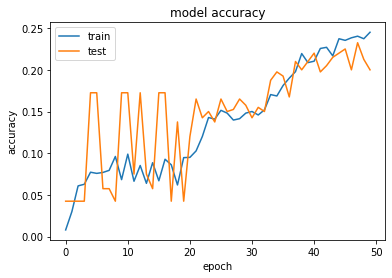

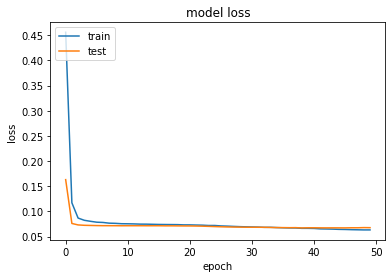

In [ ]:
# Plot loss & accuracy for training & testing sets
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Model predictions on test data

In [ ]:
y_pred_ui = lstm_model_2.predict(x=[X1_test_uic, X2_test_uic])

In [ ]:
y_pred_ui

array([[1.0483682e-02, 4.4080287e-02, 1.5532374e-03, ..., 1.8340349e-04,
        7.0518422e-06, 2.1946478e-05],
       [5.6393921e-02, 2.1317601e-02, 3.1070709e-03, ..., 9.6291660e-05,
        6.2686205e-04, 1.5237927e-04],
       [1.1559287e-01, 6.7357510e-02, 1.0050893e-02, ..., 3.8081408e-04,
        8.4319711e-04, 2.8052926e-04],
       ...,
       [1.1492857e-01, 3.0585885e-02, 3.7851334e-03, ..., 3.9794399e-05,
        4.1708350e-04, 4.8970032e-05],
       [8.6278111e-02, 1.8299520e-02, 2.9297769e-03, ..., 4.2224307e-05,
        9.0810657e-04, 9.9358331e-05],
       [1.1079729e-02, 4.7641248e-02, 1.7474592e-03, ..., 2.2214651e-04,
        8.1714461e-06, 2.6353335e-05]], dtype=float32)

In [ ]:
y_test_ui.columns

Index(['Information Technology and Services', 'Food & Beverages', 'Wholesale',
       'Retail', 'Marketing and Advertising', 'Consumer Goods',
       'Computer Software', 'Internet', 'Electrical/Electronic Manufacturing',
       'Construction',
       ...
       'Wine and Spirits', 'Graphic Design', 'Import and Export', 'Furniture',
       'Government Relations', 'Legislative Office', 'Alternative Medicine',
       'Sporting Goods', 'Animation', 'Law Enforcement'],
      dtype='object', length=141)

In [ ]:
# Create a dataframe for predictions
pred_df = pd.DataFrame(y_pred_ui, columns=y_test_ui.columns)
pred_df

,Information Technology and Services,Food & Beverages,Wholesale,Retail,Marketing and Advertising,Consumer Goods,Computer Software,Internet,Electrical/Electronic Manufacturing,Construction,Security and Investigations,Biotechnology,Chemicals,Pharmaceuticals,Law Practice,Legal Services,Management Consulting,Staffing and Recruiting,Human Resources,Nonprofit Organization Management,Higher Education,Education Management,Aviation & Aerospace,Airlines/Aviation,Medical Practice,Real Estate,Financial Services,Insurance,Banking,Hospital & Health Care,Food Production,Mechanical or Industrial Engineering,Accounting,"Health, Wellness and Fitness",Research,Government Administration,Telecommunications,Entertainment,Events Services,Hospitality,...,Publishing,Newspapers,Religious Institutions,Political Organization,Printing,Public Relations and Communications,International Trade and Development,Recreational Facilities and Services,Farming,Nanotechnology,Semiconductors,Venture Capital & Private Equity,Photography,Libraries,Railroad Manufacture,Outsourcing/Offshoring,Music,Mining & Metals,E-Learning,Executive Office,Program Development,Wireless,"Glass, Ceramics & Concrete",Motion Pictures and Film,Museums and Institutions,Fine Art,Performing Arts,Philanthropy,International Affairs,Translation and Localization,Wine and Spirits,Graphic Design,Import and Export,Furniture,Government Relations,Legislative Office,Alternative Medicine,Sporting Goods,Animation,Law Enforcement
0,0.010484,0.044080,0.001553,0.029904,0.008299,0.001431,0.005458,0.001800,0.000073,0.007744,0.001685,0.008309,0.000536,0.016630,0.000344,0.000477,0.000896,0.063258,0.001716,0.245335,0.019900,0.020726,0.000356,0.000240,0.190252,0.004048,0.039039,0.009185,0.001230,0.637382,0.003777,0.000007,0.000625,0.361004,0.013218,0.075095,0.000360,0.003540,0.000199,0.048624,...,0.000036,8.749821e-07,0.000048,0.000095,0.000015,0.000798,0.000343,0.000932,0.000016,0.000007,0.000148,0.000058,0.000005,0.000198,0.000014,0.000102,0.000015,0.000110,0.000982,0.000001,0.000026,0.000007,0.000017,0.000319,0.000030,0.000109,0.000116,0.000170,0.000108,0.000010,0.000047,0.000020,0.000015,0.000432,0.000235,0.000340,0.000065,0.000183,0.000007,0.000022
1,0.056394,0.021318,0.003107,0.051965,0.031260,0.027135,0.028664,0.012420,0.038817,0.265121,0.002037,0.017025,0.010902,0.017705,0.002632,0.002250,0.006936,0.196251,0.015562,0.086221,0.017526,0.022744,0.021140,0.012878,0.008285,0.011279,0.074839,0.011490,0.004552,0.076522,0.013393,0.033000,0.004696,0.019618,0.027849,0.078332,0.008416,0.006971,0.001054,0.012379,...,0.000657,9.277608e-06,0.000091,0.000085,0.003564,0.004492,0.000522,0.000363,0.000112,0.001127,0.003510,0.000118,0.000354,0.000577,0.000898,0.002149,0.000152,0.006686,0.001527,0.000044,0.000205,0.000503,0.000675,0.000570,0.000092,0.000100,0.000320,0.001232,0.000251,0.000108,0.000417,0.000555,0.000302,0.001226,0.000461,0.000258,0.000072,0.000096,0.000627,0.000152
2,0.115593,0.067358,0.010051,0.092459,0.063780,0.041919,0.072140,0.034995,0.026020,0.158411,0.007256,0.025088,0.012772,0.031403,0.007532,0.007513,0.017089,0.179447,0.021469,0.074164,0.010663,0.011763,0.019960,0.014928,0.027356,0.027974,0.148367,0.038516,0.019734,0.143037,0.026368,0.016123,0.014968,0.054634,0.028755,0.073368,0.015744,0.016734,0.003394,0.048659,...,0.001045,3.722545e-05,0.000171,0.000316,0.004202,0.007104,0.001707,0.001384,0.000451,0.001216,0.005090,0.000592,0.000600,0.001107,0.001016,0.003275,0.000691,0.006587,0.002449,0.000242,0.000804,0.001056,0.000891,0.001763,0.000265,0.000447,0.000544,0.002374,0.000442,0.000474,0.000776,0.001099,0.000704,0.002051,0.001255,0.000850,0.000216,0.000381,0.000843,0.000281
3,0.167379,0.035602,0.004894,0.075674,0.064770,0.063063,0.095346,0.041455,0.093956,0.317123,0.002625,0.011969,0.011574,0.013402,0.005298,0.004692,0.015264,0.193189,0.018181,0.018493,0.001683,0.001996,0.030897,0.021502,0.003365,0.019929,0.159234,0.025222,0.017136,0.033036,0.018578,0.108535,0.014178,0.008498,0.012696,0.033540,0.019805,0.

In [ ]:
# Convert dense values to 0 or 1 if value >0.5  is 1 else 0
for col in pred_df.columns:
  pred_df[col] = pred_df[col].apply(lambda x: 1 if x>0.5 else 0)

In [ ]:
pred_df

,Information Technology and Services,Food & Beverages,Wholesale,Retail,Marketing and Advertising,Consumer Goods,Computer Software,Internet,Electrical/Electronic Manufacturing,Construction,Security and Investigations,Biotechnology,Chemicals,Pharmaceuticals,Law Practice,Legal Services,Management Consulting,Staffing and Recruiting,Human Resources,Nonprofit Organization Management,Higher Education,Education Management,Aviation & Aerospace,Airlines/Aviation,Medical Practice,Real Estate,Financial Services,Insurance,Banking,Hospital & Health Care,Food Production,Mechanical or Industrial Engineering,Accounting,"Health, Wellness and Fitness",Research,Government Administration,Telecommunications,Entertainment,Events Services,Hospitality,...,Publishing,Newspapers,Religious Institutions,Political Organization,Printing,Public Relations and Communications,International Trade and Development,Recreational Facilities and Services,Farming,Nanotechnology,Semiconductors,Venture Capital & Private Equity,Photography,Libraries,Railroad Manufacture,Outsourcing/Offshoring,Music,Mining & Metals,E-Learning,Executive Office,Program Development,Wireless,"Glass, Ceramics & Concrete",Motion Pictures and Film,Museums and Institutions,Fine Art,Performing Arts,Philanthropy,International Affairs,Translation and Localization,Wine and Spirits,Graphic Design,Import and Export,Furniture,Government Relations,Legislative Office,Alternative Medicine,Sporting Goods,Animation,Law Enforcement
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
output_i = []
pred_df_list = pred_df.values.tolist()
for l in pred_df_list:
  # Get the indexes of the list if value=1 to extract prediction labels
  pred_labels = [idx for idx, value in enumerate(l) if value==1]
  output_i.append(pred_labels)

In [ ]:
output_i[:10]

[[29], [], [], [], [], [], [], [], [], []]

In [ ]:
col_list = pred_df.columns.tolist()
# Map colume name to list of indices in output_i to get the label name
dict_i = {key:value for key, value in enumerate(col_list)}
dict_i

{0: 'Information Technology and Services',
 1: 'Food & Beverages',
 2: 'Wholesale',
 3: 'Retail',
 4: 'Marketing and Advertising',
 5: 'Consumer Goods',
 6: 'Computer Software',
 7: 'Internet',
 8: 'Electrical/Electronic Manufacturing',
 9: 'Construction',
 10: 'Security and Investigations',
 11: 'Biotechnology',
 12: 'Chemicals',
 13: 'Pharmaceuticals',
 14: 'Law Practice',
 15: 'Legal Services',
 16: 'Management Consulting',
 17: 'Staffing and Recruiting',
 18: 'Human Resources',
 19: 'Nonprofit Organization Management',
 20: 'Higher Education',
 21: 'Education Management',
 22: 'Aviation & Aerospace',
 23: 'Airlines/Aviation',
 24: 'Medical Practice',
 25: 'Real Estate',
 26: 'Financial Services',
 27: 'Insurance',
 28: 'Banking',
 29: 'Hospital & Health Care',
 30: 'Food Production',
 31: 'Mechanical or Industrial Engineering',
 32: 'Accounting',
 33: 'Health, Wellness and Fitness',
 34: 'Research',
 35: 'Government Administration',
 36: 'Telecommunications',
 37: 'Entertainment',


In [ ]:
output_labels = []
for l in output_i:
  labels = [dict_i[k] for k in l]
  output_labels.append(labels)

In [ ]:
output_labels[:10]

[['Hospital & Health Care'], [], [], [], [], [], [], [], [], []]

In [ ]:
X_test_ui_preds = X_test_ui[['job_title','employment_type', 'industries']]
X_test_ui_preds['predictions_industries'] = output_labels
X_test_ui_preds.head()

,job_title,employment_type,industries,predictions_industries
84,Clinical Trial Coordinator,Full-time,"Biotechnology, Pharmaceuticals, Veterinary",[Hospital & Health Care]
2470,Crisis Worker/Police Team (190331) - 90% FTE,Full-time,"Nonprofit Organization Management, Mental Heal...",[]
2804,Drill Technician - CO7813750,Full-time,"Electrical/Electronic Manufacturing, Construct...",[]
4987,Journeyman Welders,Full-time,"Construction, Machinery, Mechanical or Industr...",[]
4924,Semi-Skilled Laborer,Full-time,"Construction, Nonprofit Organization Managemen...",[]


## Create LSTM model for Job functions

In [ ]:
def create_lstm_model_j(input_1, input_2, vocab_size, embedding_matrix, n_classes, model_name):
  # create the first submodel that accepts text data (input_1)
  embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1)
  # Add 2 bidirectional LSTMs
  x = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
  x = Bidirectional(LSTM(64))(x)

  #creates a second submodel that accepts meta data (numeric data)(input_2)
  dense_layer_1 = Dense(64, activation='relu')(input_2)
  dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)

  # Concatenate both inputs
  concat_layer = Concatenate()([x, dense_layer_2])
  dense_layer_3 = Dense(10, activation='relu')(concat_layer)
  #dense_layer_4 = Dense(32, activation='relu')(dense_layer_3)
  output = Dropout(0.1)(dense_layer_3)
  output = Dense(n_classes, activation='sigmoid')(output)
  model = Model(inputs=[input_1, input_2], outputs=output)

  # Compile the model  
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])
  print(model.summary())

  # Plot model 
  plot_model(model, to_file=f'{model_name}.png', show_shapes=True)
  
  return model

In [ ]:
# Features & labels
jobfunc_feats = df_jobfunc[df_jobfunc.columns[:10]]
jobfunc_labels = df_jobfunc[df_jobfunc.columns[10:]]

# Split the data into 80% train & 20% test set
X_train_j, X_test_j, y_train_j, y_test_j = train_test_split(jobfunc_feats, jobfunc_labels, test_size=0.2, random_state=42)

print(f'Train shape : {X_train_j.shape}')
print(f'Test shape : {X_test_j.shape}')

Train shape : (3999, 10)
Test shape : (1000, 10)


In [ ]:
n_classes_j = y_train_j.shape[1]

In [ ]:
X_train_jc = X_train_j.copy()
X_test_jc = X_test_j.copy()
y_train_jc = y_train_j.copy()
y_test_jc = y_test_j.copy()

In [ ]:
X1_train_jc = []
sentences1 = X_train_jc['job_title'].tolist()
for sen in sentences1:
    X1_train_jc.append(preprocess_text(sen))

X1_test_jc = []
sentences2 = X_test_jc['job_title'].tolist()
for sen in sentences2:
    X1_test_jc.append(preprocess_text(sen))

In [ ]:
# Convert text inputs into word vectors
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X1_train_jc)

X1_train_jc = tokenizer.texts_to_sequences(X1_train_jc)
X1_test_jc = tokenizer.texts_to_sequences(X1_test_jc)

vocab_size_jc = len(tokenizer.word_index) + 1

# Maximum sequence length of Job title
maxlen_j = 50

# Pad sequences of Job titles
X1_train_jc = pad_sequences(X1_train_jc, padding='post', maxlen=maxlen_j)
X1_test_jc = pad_sequences(X1_test_jc, padding='post', maxlen=maxlen_j)

In [ ]:
# Get embedding matrix
embedding_matrix_j = glove_embedding_matrix(vocab_size_jc)

In [ ]:
# Now let's see second input data/numeric data/meta data
X2_train_jc = X_train_jc[['Contract','Full-time', 'Internship', 'Other', 'Part-time', 'Temporary']]
X2_test_jc = X_test_jc[['Contract','Full-time', 'Internship', 'Other', 'Part-time', 'Temporary']]

In [ ]:
# Inputs for text & numeric data
input_1_j = Input(shape=(maxlen_j,))
input_2_j = Input(shape=(X2_train_jc.shape[1],))

In [ ]:
# Create LSTM model
lstm_model_3 = create_lstm_model_j(input_1_j, input_2_j, vocab_size_jc, embedding_matrix_j, n_classes_j, 'lstm_model_jobfunctions')

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 300)      989700      input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 50, 128)      186880      embedding_6[0][0]                
____________________________________________________________________________________________

In [ ]:
# Train the model 
history_3 = lstm_model_3.fit(x=[X1_train_jc, X2_train_jc], y = y_train_jc, batch_size=64, epochs=50, verbose=1, validation_split=0.1)

Epoch 1/50
57/57 [==============================] - 21s 241ms/step - loss: 0.5544 - acc: 8.3356e-04 - val_loss: 0.3639 - val_acc: 0.0000e+00
Epoch 2/50
57/57 [==============================] - 12s 214ms/step - loss: 0.2914 - acc: 0.0114 - val_loss: 0.1805 - val_acc: 0.0100
Epoch 3/50
57/57 [==============================] - 12s 217ms/step - loss: 0.1963 - acc: 0.0900 - val_loss: 0.1545 - val_acc: 0.0800
Epoch 4/50
57/57 [==============================] - 12s 216ms/step - loss: 0.1729 - acc: 0.1334 - val_loss: 0.1424 - val_acc: 0.1750
Epoch 5/50
57/57 [==============================] - 12s 213ms/step - loss: 0.1555 - acc: 0.1839 - val_loss: 0.1343 - val_acc: 0.2200
Epoch 6/50
57/57 [==============================] - 12s 216ms/step - loss: 0.1454 - acc: 0.2331 - val_loss: 0.1295 - val_acc: 0.2650
Epoch 7/50
57/57 [==============================] - 12s 213ms/step - loss: 0.1369 - acc: 0.2578 - val_loss: 0.1248 - val_acc: 0.2425
Epoch 8/50
57/57 [==============================] - 12s 215ms

Model was overfitting after 50 epochs, so 50 epochs are considered as final. Model performance can be improved by adding more data with equal distribution of sampels during training.

### Model evaluation on test data

In [ ]:
score_j = lstm_model_3.evaluate(x=[X1_test_jc, X2_test_jc], y=y_test_jc, verbose=1)

print("Test loss:", round(score_j[0],3))
print("Test Accuracy:", round(score_j[1],3))

32/32 [==============================] - 1s 34ms/step - loss: 0.1546 - acc: 0.3730
Test loss: 0.155
Test Accuracy: 0.373


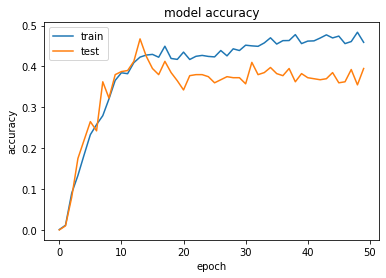

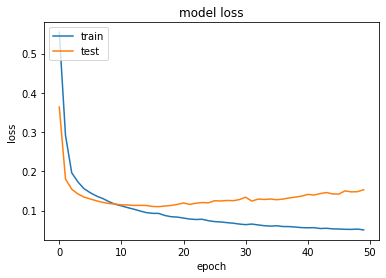

In [ ]:
# Plot loss & accuracy for training & testing sets
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Model predictions on test data

In [ ]:
y_pred_j = lstm_model_3.predict(x=[X1_test_jc, X2_test_jc])
y_pred_j

array([[6.5019680e-07, 2.8152764e-03, 8.2015991e-03, ..., 3.2168627e-04,
        1.4109126e-05, 1.3113022e-04],
       [3.2488227e-02, 8.6592609e-01, 9.7256971e-06, ..., 3.6031011e-05,
        2.5599301e-03, 2.8847188e-02],
       [7.2738886e-01, 9.1777396e-01, 1.7007107e-05, ..., 8.4799528e-04,
        2.0191073e-04, 6.5199101e-06],
       ...,
       [2.0834541e-07, 3.9445221e-02, 2.8761569e-05, ..., 5.5968349e-06,
        1.4377026e-08, 2.3485455e-07],
       [8.8611245e-04, 2.2231758e-02, 1.5279651e-04, ..., 1.1815697e-05,
        2.6534490e-08, 3.7224329e-10],
       [3.8635731e-04, 5.1686138e-02, 2.3526311e-02, ..., 7.5420439e-03,
        7.2854433e-05, 1.9139051e-04]], dtype=float32)

In [ ]:
# Create a dataframe for predictions
pred_df1 = pd.DataFrame(y_pred_j, columns=y_test_jc.columns)
pred_df1

,Engineering,Information Technology,Marketing,Sales,Quality Assurance,Management,Manufacturing,Legal,Design,Art/Creative,Education,Training,Health Care Provider,Accounting/Auditing,Consulting,Analyst,Human Resources,Business Development,Research,Production,Distribution,General Business,Finance,Supply Chain,Customer Service,Administrative,Public Relations,Writing/Editing,Project Management,Science,Strategy/Planning,Advertising,Product Management,Purchasing
0,6.501968e-07,0.002815,0.008202,4.616562e-02,1.643002e-03,0.047956,1.700670e-03,1.476055e-02,3.980840e-05,1.358755e-06,1.560014e-02,1.712644e-02,6.768121e-01,1.112489e-04,0.008642,1.111635e-04,1.022100e-03,9.427270e-02,6.158054e-04,2.427965e-03,2.885163e-03,1.135057e-02,7.164180e-04,4.336327e-03,7.114407e-02,6.573898e-02,8.181930e-04,2.542406e-03,1.919648e-02,9.984970e-04,0.001931,3.216863e-04,1.410913e-05,1.311302e-04
1,3.248823e-02,0.865926,0.000010,1.969646e-07,4.284084e-04,0.963247,6.254758e-01,8.903444e-04,1.400417e-01,1.128766e-01,1.161875e-09,3.941631e-09,2.196431e-04,8.778716e-07,0.001711,3.205746e-03,6.108692e-05,1.366242e-06,1.115590e-03,6.456435e-03,1.097483e-04,8.511841e-04,1.104284e-08,2.191788e-02,4.358953e-02,3.500682e-02,4.494945e-06,3.584904e-05,5.091764e-01,3.532380e-03,0.000756,3.603101e-05,2.559930e-03,2.884719e-02
2,7.273889e-01,0.917774,0.000017,9.149386e-06,1.589063e-02,0.011729,7.637471e-03,9.613159e-06,3.848130e-02,1.738411e-02,6.112419e-06,7.152783e-06,6.237980e-07,9.765923e-04,0.017364,6.844521e-03,1.498021e-05,1.322107e-07,1.297110e-02,7.404715e-03,1.732409e-04,5.213118e-06,5.400278e-05,1.147592e-04,8.719355e-03,8.913446e-06,1.418423e-05,6.869553e-06,7.692064e-05,2.796024e-03,0.000444,8.479953e-04,2.019107e-04,6.519910e-06
3,4.741549e-04,0.007308,0.000228,7.421654e-08,1.355966e-05,0.010899,3.527313e-03,3.330028e-10,2.947245e-05,6.928647e-07,1.694734e-09,1.494315e-09,3.634723e-06,3.450157e-09,0.000106,4.753252e-10,2.422246e-11,1.539858e-08,1.444191e-08,9.498739e-05,5.689044e-08,1.253450e-09,7.367511e-11,7.315865e-08,1.270479e-06,1.000084e-08,1.594910e-05,3.812524e-05,8.496436e-07,1.173944e-05,0.000002,1.150660e-05,7.952134e-08,7.343147e-10
4,2.518075e-05,0.000872,0.001249,2.836859e-05,1.547039e-04,0.001107,5.123913e-04,3.916498e-08,6.013295e-06,1.048983e-07,4.926666e-06,3.914359e-06,1.633465e-04,1.004882e-07,0.000430,1.936693e-08,2.392455e-08,5.103271e-06,4.583234e-07,1.926124e-04,1.505879e-06,1.203124e-07,5.069340e-08,6.233448e-07,1.322854e-05,6.228349e-07,8.867429e-05,1.328588e-04,9.435250e-07,5.322743e-05,0.000009,3.486442e-05,7.816762e-08,2.402725e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.237395e-12,0.000039,0.000005,4.272723e-02,5.396725e-07,0.000004,5.027060e-12,5.024159e-07,1.149634e-09,1.353603e-12,7.165611e-08,3.412364e-08,1.092289e-08,2.244115e-04,0.000145,9.313439e-08,6.879744e-11,1.299381e-04,1.332521e-08,5.748976e-07,3.469830e-07,2.781141e-06,3.335187e-02,1.489597e-08,9.026779e-05,5.620757e-07,1.590781e-09,1.793812e-08,3.837647e-09,9.383589e-11,0.000003,2.440464e-09,4.981190e-12,2.626456e-11
996,9.105987e-09,0.000026,0.000997,1.665890e-03,1.680612e-05,0.000003,2.313280e-08,1.632620e-07,1.105762e-07,5.274473e-10,8.512751e-06,4.652713e-06,1.249526e-05,1.119761e-06,0.000257,2.226936e-08,1.090141e-08,5.729109e-05,7.568553e-08,9.125457e-06,2.288984e-07,3.156549e-07,2.184131e-05,2.783423e-08,3.407512e-06,1.001301e-06,5.798939e-06,2.281481e-05,4.290908e-09,4.389113e-07,0.000002,1.682351e-06,1.423119e-10,3.281928e-11
997,2.083454e-07,0.039445,0.000029,3.157380e-02,2.493560e-04,0.000039,5.268342e-09,1.070535e-02,1.831797e-05,9.327754e-07,1.647234e-03,1.309633e-03,3.605748e-05,2.193784e-01,0.006989,1.334596e-02,1.492573e-05,8.241534e-04,2.894193e-03,2.754331e-04,3.044307e-04,2.527595e-03,7.170489e-01,4.744071e-05,5.520850e-02,5.326957e-03,8.584284e-07,3.811108e-06,1.054278e-05,2.167622e-06,0.001886,5.596835e-06,1.437703e-08,2.348546e-07
99

In [ ]:
# Convert dense values to 0 or 1 if value >0.5  is 1 else 0
for col in pred_df1.columns:
  pred_df1[col] = pred_df1[col].apply(lambda x: 1 if x>0.5 else 0)

In [ ]:
pred_df1

,Engineering,Information Technology,Marketing,Sales,Quality Assurance,Management,Manufacturing,Legal,Design,Art/Creative,Education,Training,Health Care Provider,Accounting/Auditing,Consulting,Analyst,Human Resources,Business Development,Research,Production,Distribution,General Business,Finance,Supply Chain,Customer Service,Administrative,Public Relations,Writing/Editing,Project Management,Science,Strategy/Planning,Advertising,Product Management,Purchasing
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
output_j = []
pred_df1_list = pred_df1.values.tolist()
for l in pred_df1_list:
  # Get the indexes of the list if value=1 to extract prediction labels
  pred_labels = [idx for idx, value in enumerate(l) if value==1]
  output_j.append(pred_labels)

In [ ]:
output_j[:10]

[[12], [1, 5, 6, 28], [0, 1], [], [], [1, 5], [0, 1], [0, 1], [], [1]]

In [ ]:
col_list = pred_df1.columns.tolist()
# Map colume name to list of indices in output_i to get the label name
dict_j = {key:value for key, value in enumerate(col_list)}
dict_j

{0: 'Engineering',
 1: 'Information Technology',
 2: 'Marketing',
 3: 'Sales',
 4: 'Quality Assurance',
 5: 'Management',
 6: 'Manufacturing',
 7: 'Legal',
 8: 'Design',
 9: 'Art/Creative',
 10: 'Education',
 11: 'Training',
 12: 'Health Care Provider',
 13: 'Accounting/Auditing',
 14: 'Consulting',
 15: 'Analyst',
 16: 'Human Resources',
 17: 'Business Development',
 18: 'Research',
 19: 'Production',
 20: 'Distribution',
 21: 'General Business',
 22: 'Finance',
 23: 'Supply Chain',
 24: 'Customer Service',
 25: 'Administrative',
 26: 'Public Relations',
 27: 'Writing/Editing',
 28: 'Project Management',
 29: 'Science',
 30: 'Strategy/Planning',
 31: 'Advertising',
 32: 'Product Management',
 33: 'Purchasing'}

In [ ]:
output_labels = []
for l in output_j:
  labels = [dict_j[k] for k in l]
  output_labels.append(labels)

In [ ]:
output_labels[:10]

[['Health Care Provider'],
 ['Information Technology',
  'Management',
  'Manufacturing',
  'Project Management'],
 ['Engineering', 'Information Technology'],
 [],
 [],
 ['Information Technology', 'Management'],
 ['Engineering', 'Information Technology'],
 ['Engineering', 'Information Technology'],
 [],
 ['Information Technology']]

In [ ]:
X_test_j_preds = X_test_j[['job_title','employment_type', 'job_functions']]
X_test_j_preds['predictions_job_functions'] = output_labels
X_test_j_preds.head()

,job_title,employment_type,job_functions,predictions_job_functions
84,Clinical Trial Coordinator,Full-time,"Research, Analyst, Information Technology",[Health Care Provider]
2470,Crisis Worker/Police Team (190331) - 90% FTE,Full-time,Administrative,"[Information Technology, Management, Manufactu..."
2804,Drill Technician - CO7813750,Full-time,"Engineering, Information Technology","[Engineering, Information Technology]"
4987,Journeyman Welders,Full-time,Other,[]
4924,Semi-Skilled Laborer,Full-time,Other,[]


### Combine all predictions

In [ ]:
X_test_j_preds

,job_title,employment_type,job_functions,predictions_job_functions
84,Clinical Trial Coordinator,Full-time,"Research, Analyst, Information Technology",[Health Care Provider]
2470,Crisis Worker/Police Team (190331) - 90% FTE,Full-time,Administrative,"[Information Technology, Management, Manufactu..."
2804,Drill Technician - CO7813750,Full-time,"Engineering, Information Technology","[Engineering, Information Technology]"
4987,Journeyman Welders,Full-time,Other,[]
4924,Semi-Skilled Laborer,Full-time,Other,[]
...,...,...,...,...
4486,Loss Adjuster,Full-time,Other,[]
1918,Community Relations Director,Full-time,Other,[]
4696,Corporate Law Clerk,Full-time,Legal,[Finance]
3360,Lathe Operator,Full-time,Other,[]


In [ ]:
X_test_preds

,job_title,employment_type,original_seniority_level,predictions_seniority_level
84,Clinical Trial Coordinator,Full-time,Entry level,Entry level
2470,Crisis Worker/Police Team (190331) - 90% FTE,Full-time,Entry level,Entry level
2804,Drill Technician - CO7813750,Full-time,Entry level,Entry level
4987,Journeyman Welders,Full-time,Entry level,Entry level
4924,Semi-Skilled Laborer,Full-time,Entry level,Entry level
...,...,...,...,...
4486,Loss Adjuster,Full-time,Mid-Senior level,Entry level
1918,Community Relations Director,Full-time,Director,Associate
4696,Corporate Law Clerk,Full-time,Entry level,Entry level
3360,Lathe Operator,Full-time,Entry level,Entry level


In [ ]:
X_test_ui_preds

,job_title,employment_type,industries,predictions_industries
84,Clinical Trial Coordinator,Full-time,"Biotechnology, Pharmaceuticals, Veterinary",[Hospital & Health Care]
2470,Crisis Worker/Police Team (190331) - 90% FTE,Full-time,"Nonprofit Organization Management, Mental Heal...",[]
2804,Drill Technician - CO7813750,Full-time,"Electrical/Electronic Manufacturing, Construct...",[]
4987,Journeyman Welders,Full-time,"Construction, Machinery, Mechanical or Industr...",[]
4924,Semi-Skilled Laborer,Full-time,"Construction, Nonprofit Organization Managemen...",[]
...,...,...,...,...
4486,Loss Adjuster,Full-time,Insurance,[]
1918,Community Relations Director,Full-time,"Nonprofit Organization Management, Health, Wel...",[]
4696,Corporate Law Clerk,Full-time,"Staffing and Recruiting, Financial Services, A...",[]
3360,Lathe Operator,Full-time,"Construction, Machinery, Staffing and Recruiting",[]


In [ ]:
df_final = X_test_preds 
df_final['industries'] = X_test_ui_preds['industries'].values
df_final['predictions_industries'] = X_test_ui_preds['predictions_industries'].values 
df_final['job_functions'] = X_test_j_preds['job_functions'].values 
df_final['predictions_job_functions'] = X_test_j_preds['predictions_job_functions'].values

In [ ]:
df_final.head()

,job_title,employment_type,original_seniority_level,predictions_seniority_level,industries,predictions_industries,job_functions,predictions_job_functions
84,Clinical Trial Coordinator,Full-time,Entry level,Entry level,"Biotechnology, Pharmaceuticals, Veterinary",[Hospital & Health Care],"Research, Analyst, Information Technology",[Health Care Provider]
2470,Crisis Worker/Police Team (190331) - 90% FTE,Full-time,Entry level,Entry level,"Nonprofit Organization Management, Mental Heal...",[],Administrative,"[Information Technology, Management, Manufactu..."
2804,Drill Technician - CO7813750,Full-time,Entry level,Entry level,"Electrical/Electronic Manufacturing, Construct...",[],"Engineering, Information Technology","[Engineering, Information Technology]"
4987,Journeyman Welders,Full-time,Entry level,Entry level,"Construction, Machinery, Mechanical or Industr...",[],Other,[]
4924,Semi-Skilled Laborer,Full-time,Entry level,Entry level,"Construction, Nonprofit Organization Managemen...",[],Other,[]


Finall insights:
* Data is not sufficient for better model performance.
* We found classess/labels are highly imbalanced (some labels have high number of samples compared to other). This should be avoided to get good model performance. Get data with balanced classes.